In [1]:
from kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYI as std

In [2]:
SAMPLES = 256
SEED = 2023

# Demo 1: Hamiltonian overrotation 

This demo shows how overrotation error is amplified in a period fashion in germs

In [3]:
"""setup the FOGI model"""
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
target_model = mdl_datagen.copy()

In [4]:
"""identify the hamiltonian component on the X gate"""
noise_vector = np.zeros(mdl_datagen.num_params)
print(mdl_datagen.fogi_errorgen_component_labels())
print(mdl_datagen.fogi_errorgen_component_labels()[6])

('H(X:0)_[]', 'H(Y:0)_[]', 'H(Z:0)_[]', 'S(X:0)_[]', 'S(Y:0)_[]', 'S(Z:0)_[]', 'H(X:0)_Gxpi2:0', 'S(X:0)_Gxpi2:0', '(0.5 S(Y:0) + 0.5 S(Z:0))_Gxpi2:0', 'H(Y:0)_Gypi2:0', '(0.5 S(X:0) + 0.5 S(Z:0))_Gypi2:0', 'S(Y:0)_Gypi2:0', 'ga(-H(Z:0))_Gypi2:0 - ga(-H(Z:0))_Gxpi2:0', 'ga(H(Y:0))_rho0 - ga(H(Y:0))_Gxpi2:0', 'ga(-H(Y:0))_Mdefault - ga(-H(Y:0))_Gxpi2:0', 'ga(H(X:0))_rho0 - ga(H(X:0))_Gypi2:0', 'ga(-H(X:0))_Mdefault - ga(-H(X:0))_Gypi2:0', 'ga(-0.5 S(X:0) - 0.5 S(Y:0))_Mdefault - ga(-0.5 S(X:0) - 0.5 S(Y:0))_rho0')
H(X:0)_Gxpi2:0


In [5]:
from pygsti.circuits import Circuit
circs = []
for germ_pow in [1, 4, 16, 32]:
    circs.append(Circuit([('Gxpi2', 0)]*germ_pow))

In [6]:
xnoise = np.linspace(-0.1, 0.1, 50)
pvecs = np.zeros((4, 50))
for idx, x in enumerate(xnoise):
    noise_vector[6] = x
    mdl_datagen.from_vector(noise_vector)
    for c in range(4):
        pvecs[c, idx] = vector_from_outcomes(mdl_datagen.probabilities(circs[c]), 2**circs[c].width)[0]

Text(0.5, 1.0, '32 repetitions')

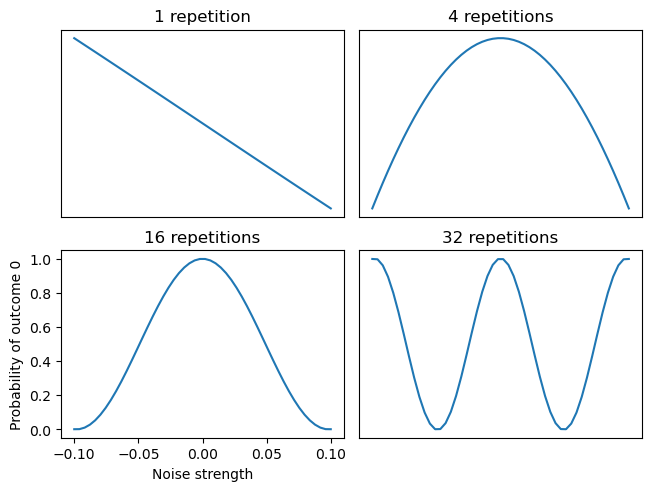

In [7]:
fig, axs = plt.subplots(2, 2, constrained_layout=True)
axs[0, 0].plot(xnoise, pvecs[0, :])
axs[0, 1].plot(xnoise, pvecs[1, :])
axs[1, 0].plot(xnoise, pvecs[2, :])
axs[1, 1].plot(xnoise, pvecs[3, :])

xax = axs[0,0].get_xaxis()
xax = xax.set_visible(False)
xax = axs[0,1].get_xaxis()
xax = xax.set_visible(False)
xax = axs[1,1].get_xaxis()
xax = xax.set_visible(False)
yax = axs[0, 0].get_yaxis()
yax = yax.set_visible(False)
yax = axs[0, 1].get_yaxis()
yax = yax.set_visible(False)
yax = axs[1, 1].get_yaxis()
yax = yax.set_visible(False)
axs[1, 0].set_xlabel('Noise strength')
axs[1, 0].set_ylabel('Probability of outcome 0')
axs[0, 0].set_title('1 repetition')
axs[0, 1].set_title('4 repetitions')
axs[1, 0].set_title('16 repetitions')
axs[1, 1].set_title('32 repetitions')

# Demo 2: 1-parameter learning

This demo shows how the filter learns in a 1-parameter model

In [4]:
"""setup the FOGI model"""
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
target_model = mdl_datagen.copy()

In [93]:
"""put hamiltonian noise on the x gate"""
noise_vector = np.zeros(mdl_datagen.num_params)
noise_vector[6] = 0.05

In [124]:
"""define our circuits"""
from pygsti.circuits import Circuit
circs = []
for germ_pow in [1, 2, 3, 4, 5, 8, 16, 32]:
    circs.append(Circuit([('Gxpi2', 0)]*germ_pow))

In [125]:
"""simulate noisy observations"""
np.random.seed(SEED)
observations = []
for circ in circs:
    p_true = vector_from_outcomes(mdl_datagen.probabilities(circ), 2**circ.width)
    observations.append(np.random.multinomial(SAMPLES, p_true))

In [168]:
filter_model = target_model.copy()
estimate = np.zeros(filter_model.num_params)
x_prior = 0
P_prior = 0.5
xhist = [x_prior]
Phist = [P_prior]
for idx, circ in enumerate(circs):
    estimate[6] = x_prior
    filter_model.from_vector(estimate)
    p_pred = vector_from_outcomes(filter_model.probabilities(circ), 2**circ.width)
    p_obs = (observations[idx]/SAMPLES)
    noise = dirichlet_covar(observations[idx])
    jac = matrix_from_jacob(filter_model.sim.dprobs(circ), 2**circ.width)
    H = jac[:, 6]
    Kgain = P_prior*H.T@np.linalg.pinv(P_prior*H@H.T + noise, 1e-6)
    x_post = x_prior + Kgain@(p_obs - p_pred)
    P_post = P_prior - Kgain@H*P_prior
    xhist.append(x_post)
    Phist.append(P_post)
    x_prior = x_post 
    P_prior = P_post

In [167]:
print(Phist)

[0.5, 0.5, 0.499999999941692, 0.499999999941692, 0.49962591277286766, 0.49962591277286766, 0.49962591277286766, 0.49962591277286766, 0.49962591277286766]


In [163]:
print(xhist)

[0, 0.0, 2.507426890211013e-05, 2.507426890211013e-05, 0.11652287940214125, 0.11652287940214125, 0.11652287940214125, 0.11652287940214125, 0.11652287940214125]
